In [1]:
## Load necessary libraries

### General purpose
import numpy as np
import pandas as pd
from math import pi
from glob import glob
import string
import warnings

### Image analysis
from skimage import io
from skimage.morphology import skeletonize, medial_axis, binary_closing, binary_erosion, binary_dilation
from skimage.measure import regionprops_table
from scipy.ndimage import distance_transform_edt, binary_fill_holes
from cv2 import findNonZero

### Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

### Bayesian analysis
import pymc
from pymc import HalfCauchy, Model, Normal, sample

letters = list(string.ascii_uppercase)

warnings.filterwarnings("ignore")


In [29]:
## Define custom function for cell size measurement

### Transform a list of segmentation images into a list of single cells
def SingleCellLister(maskList:list) -> list:
    
    AllCells = []

    for mask in maskList:
        reg = regionprops_table(mask,properties=['image'])
        Cells = [binary_fill_holes(image) for image in reg['image']]
        AllCells += Cells

    return AllCells

### From a set of coordinate points, check the neighbor pixels of the object. Pixels that have only 1 neighbor are the end points and their coordinates are extracted
def get_end_pnts(pnts:np.array, img:np.array)->list:

    ## pnts should be and array of shape (N,2), where N is the amount of non-zero points found using cv2's "findNonZero" function on an image skeleton
    ## img should be the skeleton of the cell as a binary image. Try to ensure that the skeleton doesn't have "branches", as this will give multiple end points instead of the desired two
    
    extremes = []    

    ## The loop iterates through every point, calculating the number of neighbors
    ## The skeleton is a boolean image (0,1), so every one of it's pixel values is 1. 
    
    for p in pnts:
        x = p[0]
        y = p[1]
        n = 0        
        n += img[y - 1,x]
        n += img[y - 1,x - 1]
        n += img[y - 1,x + 1]
        n += img[y,x - 1]    
        n += img[y,x + 1]    
        n += img[y + 1,x]    
        n += img[y + 1,x - 1]
        n += img[y + 1,x + 1]

        ### In the case that your boolean has a different value (i.e., 255), make sure to dive n by that number, n = 255
        ### Change the if condition to represent the value more accurately (1.0)
        if n == 1:
            extremes.append(p)
            
    return extremes

## Calculate cell surface area and volume across a single cell
def Surface2Volume(distanceSkeleton:np.array,end1,end2,pixsize:float=33.02/512,pi=pi):
   
    Surface_area = 2*pi*((end1**2) + (end2**2) + np.sum(pixsize*distanceSkeleton[1:-1]))

    Volume = pi*((end1**3)*2/3 +(end2**3)*2/3 + np.sum(pixsize*(distanceSkeleton[1:-1]**2)))

    return Surface_area, Volume

### From a skeleton representation of a cell and the cell's distance transform, calculate the length and width of the cell
def SkeletonMeasure(Skeleton:np.array,Distances:np.array,per_position_width:bool=False,pixsize:float=33.02/512):

    ## Obtain distance value for the skeleton coordinates
    dskel = Skeleton*Distances*pixsize
    
    ## Find the coordinates of the skeleton points. Make sure to transform the image out of boolean, otherwise findNonZero will give an error
    pnts = np.squeeze(findNonZero(np.uint8(Skeleton)))    

    
    ## Find the end points of the skeleton, and extract their coordinates
    
    try:
        extremes = get_end_pnts(pnts,Skeleton)
        end1_y,end1_x = extremes[0]
        end2_y,end2_x = extremes[1]
    except:
        end1_x,end1_y = 0,0
        end2_x,end2_y = 0,0
        pass
        
    ## Measuring cell width is the easiest, as you simply take every distance value that's on the skeleton and multiply it by two 
    ### Store it as an array so you can extract summary statistics from it (mean, median, sd, etc)
    ### However, in heavily curved cells this won't allow you to see position-specific width
    
    flatskel = dskel.flatten()
    flatskel = flatskel[flatskel.nonzero()]

    w = flatskel*2

    ## Now to calculate length, you simply can't take the distances between the ends, as if the cell is curved, the result is wrong
    ## Insted, we iterate through the coordinates given by findNonZero: starting from one of the extremes, we measure the distance to all points, remove the point with distance 0, and append the minimum found (closest point)
    ## Doing this, allows is to properly quantify the length accross the whole skeleton
    
    startpoint = np.array([end1_x,end1_y])
    endpoint = np.array([end2_x,end2_y])

    L = []
    L.append(dskel[startpoint[0],startpoint[1]])
    
    if end1_x == 0 & end1_y == 0 & end2_x == 0 & end2_y == 0:
        extremes = [0,0]

    else:
        targetpoints = np.array([np.array([y,x]) for x,y in pnts])

    ## For our cells, we assume them to be spherocylinder with hemispherical caps having rotational symmetry accross the whole cell. 
    ## We also assume that the end of the skeleton is the point where the distance to the pole is the same as the shortest distance measured at that point, or cell width
    
    
    ### OPTIONAL: if you want to calculate the per-position width make sure to enable the flag in the function call

    if per_position_width: 
        w = []
        w.append(dskel[startpoint[0],startpoint[1]]*2)

    if len(extremes) == 2:
    
        ## Now iterate through the points
        try:
            while len(targetpoints)>1:

                ## Calculate euclidean distance between the start point and every other point
                euc_dists = np.sqrt(np.sum((startpoint-targetpoints)**2,axis=1))

                ## Remove the reference point and its value form the point and distance arrays
                targetpoints = targetpoints[euc_dists.nonzero()]
                euc_dists = euc_dists[euc_dists.nonzero()]

                ## Append the distance to the closest point (the neighbor in the skeleton)
                L.append(euc_dists.min())

                ## Update the starting point to be the one found as neighbor
                startpoint = targetpoints[euc_dists==euc_dists.min()]

                ### OPTIONAL: if you want to calculate the per-position width make sure to enable the flag in the function call
                if per_position_width: w.append(dskel[startpoint[0,0],startpoint[0,1]]*2)

            ## Add the length value of the other end of the skeleton
            L.append(dskel[endpoint[0],endpoint[1]])
        except:
            pass
    
    else: L.append(0)
    

    ## At the end of the loop, you'll end with the list of length between points. To calculate the cell length, just add al those values
    ## The function returns the arrays for width and length, that way the can be inspected and summary statistics can be easily extracted for cell width
    ## The values will be in pixels, that way it can appropriately transformed to proper units (i.e., µm) based on the microscope sampling 

    ## Finally, compute surface area and volume
    spher1 = dskel[end1_x,end1_y]
    spher2 =  dskel[end2_x,end2_y]
    S,V = Surface2Volume(distanceSkeleton=flatskel,end1=spher1,end2=spher2)
    
    
    return np.array(w),np.array(L)*pixsize, S,V

## From a list of segmentation images, use the previous functions and obtain a dataframe
def SizeDataFrame(celllist:list):

    cells = [np.pad(binary_closing(cell),pad_width=5) for cell in celllist]
    skeletons = [skeletonize(cell) for cell in cells]
    distances = [distance_transform_edt(cell) for cell in cells]

    measures = [SkeletonMeasure(skel,dist) for skel,dist in zip(skeletons,distances)]

    w = [metric[0].mean() for metric in measures]
    L = [metric[1].sum() for metric in measures]
    S = [metric[2] for metric in measures]
    V = [metric[3] for metric in measures]
    
    df = pd.DataFrame()

    df.insert(0,'Width',w)
    df.insert(1,'Length',L)
    df.insert(2,'SurfaceArea',S)
    df.insert(3,'Volume',V)
    
    return df

In [36]:
GT_cells_path = '/Users/reyesmatte/Desktop/SingleCells/Ecoli/Ecoli_GT/'
Omni_cells_path = '/Users/reyesmatte/Desktop/SingleCells/Ecoli/Ecoli_Omni/'

cells = sorted(glob(f'{GT_cells_path}*.tif'))

cells = [cell.split('/')[-1].split('.')[0] for cell in cells]

print(len(cells))

gt_masks = [binary_fill_holes(io.imread(f'{GT_cells_path}{cell}.tif')) > 0 for cell in cells]
omni_masks = [binary_fill_holes(io.imread(f'{Omni_cells_path}{cell}.tif')) > 0 for cell in cells]


864


In [37]:
metrics = ['Width','Length','SurfaceArea','Volume']
metrics_GT = ['Width_GT','Length_GT','SurfaceArea_GT','Volume_GT']
metrics_Omni = ['Width_Omni','Length_Omni','SurfaceArea_Omni','Volume_Omni']

GT_sizes = SizeDataFrame(gt_masks)
Omni_sizes = SizeDataFrame(omni_masks)

GT_sizes.columns = metrics_GT
Omni_sizes.columns = metrics_Omni

joint_df = pd.concat([GT_sizes,Omni_sizes],axis=1)

joint_df.to_csv('/Users/reyesmatte/Desktop/SingleCells/Ecoli/SingleCells_measurements.csv')

## Parameter sampling for error propagation on segmentation results

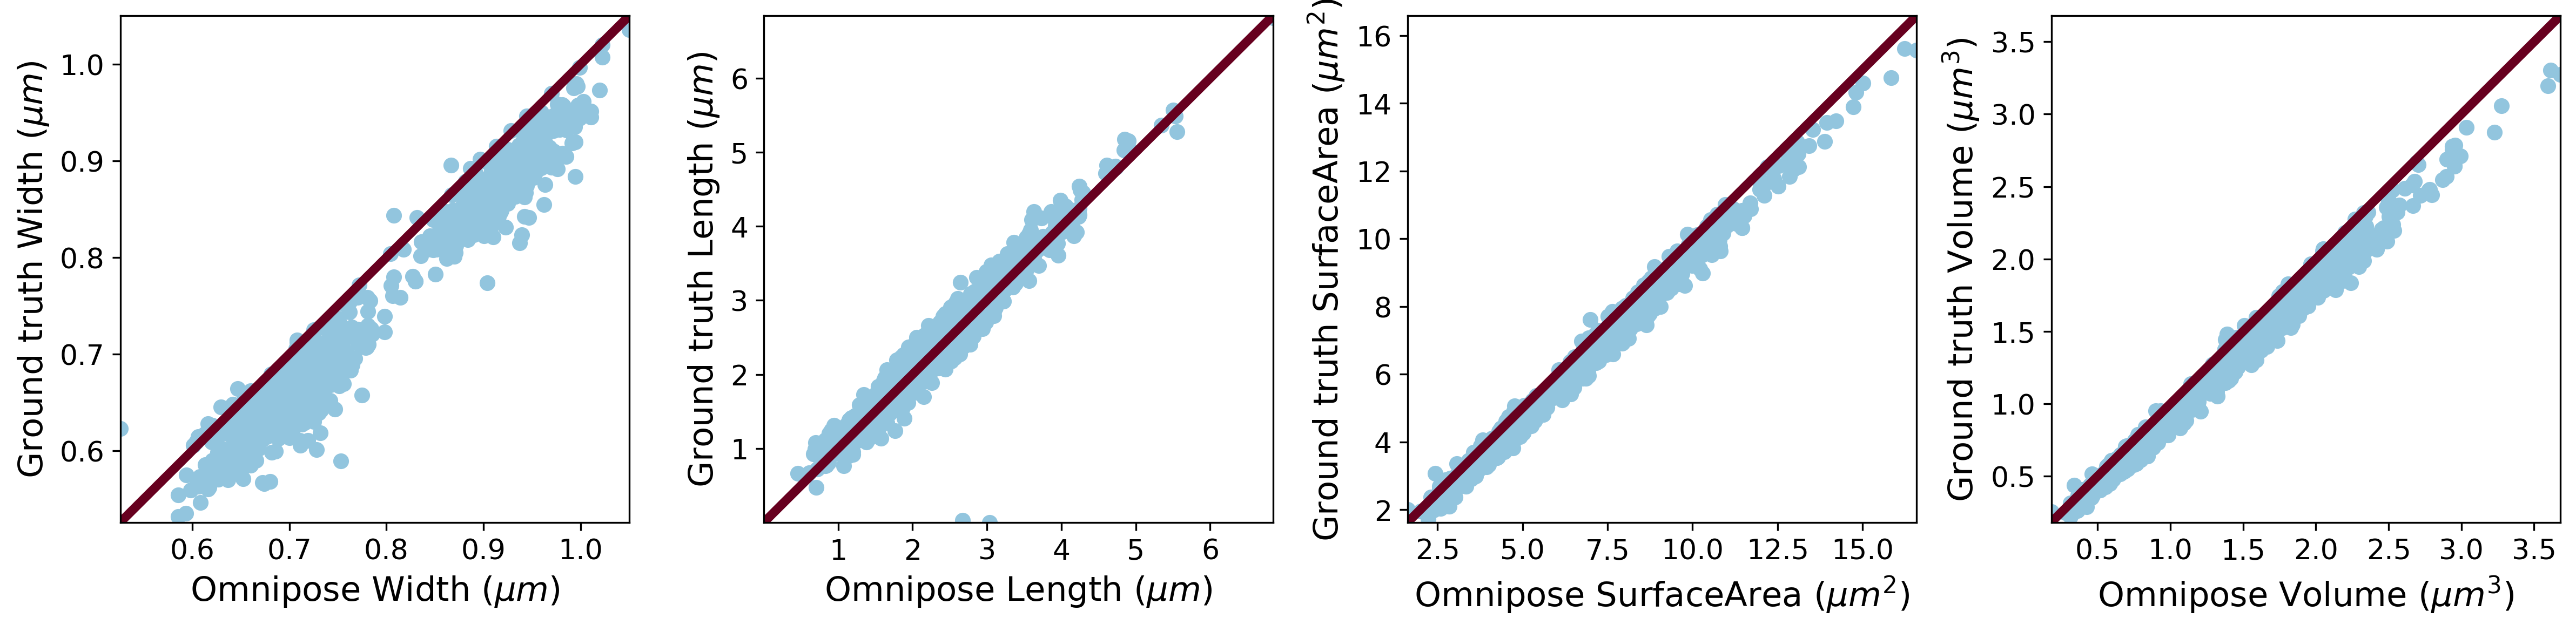

In [3]:
## Load the data and plot the metrics

full_data = pd.read_csv('/Users/reyesmatte/Desktop/SingleCells/Ecoli/SingleCells_measurements.csv')

metrics = ['Width','Length','SurfaceArea','Volume']

plt.figure(figsize=(16,4),dpi=300)

i = 1

for metric in metrics:

    if metric == 'SurfaceArea':
        unit = '$µm^2$'
    elif metric == 'Volume':
        unit = '$µm^3$'
    else:
        unit = '$µm$'
    
    y = np.array(full_data[f'{metric}_GT'])
    x = np.array(full_data[f'{metric}_Omni'])
    xy = np.stack([x,y])
    lowlim = xy.min()
    highlim = xy.max()

    plt.subplot(1,4,i)
    plt.scatter(x,y,c='#92c5de')
    plt.plot([lowlim,highlim],[lowlim,highlim],c='#67001f',linewidth=4)

    plt.xlabel(f'Omnipose {metric} ({unit})',fontsize=15)
    plt.ylabel(f'Ground truth {metric} ({unit})',fontsize=15)
    plt.xlim(lowlim,highlim)
    plt.ylim(lowlim,highlim)
    plt.xticks(fontsize=12.5)
    plt.yticks(fontsize=12.5)

    i+=1

plt.tight_layout()
plt.savefig('/Users/reyesmatte/Desktop/SingleCells/Ecoli/OmnivGT_measurements.png')

### How to perform the transformations?

We'll use the [PYMC](https://www.pymc.io/welcome.html) library for sampling pairs of values (slope, intercept and standard deviation) using a Bayesian statistics approach. Since we have four different metrics in our dataframe, we'll iterate through them to perform the sampling. The workflos is as follows, borrowing heavily from the [GLM example](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html) in the PYMC documentation:

- Define your x and y vectors for which you want to perform the linear fit
  * In our case, x is the `Ground Truth` measurements, and y the `Omnipose` measurements in our data, as we wish to go from a segmentation-resulting size to a ground-truth size

- Define the prior distributions for sampling the parameters. In this case, we'll use a normal distribution for both slope and intercept, and a half-Cauchy for the standard deviation

- Define the "likelihood", or the function that our data will follow. For our data, this is: y = intercept + slope * x

- Sample values that fit the data. PYMC uses the [NUTS sampler](https://arxiv.org/abs/1111.4246). You can define the number of chains and the number of draws per chain

- The result will be one distribution of sampled values per chain, per parameter. You can inspect them and see, for example, their spread and similarity

In [39]:
## Construct iterative loop through measurements

metrics = ['Width','Length','SurfaceArea','Volume']

df_list = []

for metric in metrics:

    y = np.array(full_data[f'{metric}_GT'])
    x = np.array(full_data[f'{metric}_Omni'])

    RANDOM_SEED = 8927
    rng = np.random.default_rng(RANDOM_SEED)

    with Model() as model:

        ## Define priors
        sigma = HalfCauchy('sigma', beta=10)
        intercept = Normal('Intercept', 0, sigma=20)
        slope = Normal('slope', 0, sigma=20)

        ## Define likelihood
        likelihood = Normal('y', mu = intercept + slope * x, sigma=sigma, observed=y)

        ## For inference, draw N posterior samples
        idata = sample(3000)

    ## Obtain posterior distributions
    post_slope = np.array(idata.posterior.slope)
    post_intercept = np.array(idata.posterior.Intercept)
    post_sigma = np.array(idata.posterior.sigma)

    ## Each array has a shape of (4,3000), denoting the chains and draws, respectively
    ## Iterate through each chain to keep the information for sampling after

    for i in range(post_slope.shape[0]):
        
        mini_df = pd.DataFrame()
        mini_df.insert(0,'Sigma',post_sigma[i])
        mini_df.insert(0,'Intercept',post_intercept[i])
        mini_df.insert(0,'Slope',post_slope[i])
        mini_df.insert(0,'Chain',i)
        mini_df.insert(0,'Metric',metric)

        df_list.append(mini_df)

df_posteriors = pd.concat(df_list,ignore_index=True)
df_posteriors.to_csv('/Users/reyesmatte/Desktop/SingleCells/Ecoli/posterior_segmentation_measurements.csv')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, slope]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 3 seconds.


In [40]:
df_posteriors = pd.read_csv('/Users/reyesmatte/Desktop/SingleCells/Ecoli/posterior_segmentation_measurements.csv')

In [91]:
## Report sampling examples for the cell size metrics, as well as the distributions of the sampled slope, intercept, and standard deviation

fig,ax = plt.subplots(figsize=(24,24),dpi=300, nrows=4, ncols=4)

k = 0
c = 0
r = 0

for metric in metrics:

    if metric == 'SurfaceArea':
        unit = '$µm^2$'
        metric_ = 'Surface Area'
    elif metric == 'Volume':
        unit = '$µm^3$'
        metric_ = metric
    else:
        unit = '$µm$'
        metric_ = metric
        
    y = np.array(full_data[f'{metric}_GT'])
    x = np.array(full_data[f'{metric}_Omni'])
    xy = np.stack([x,y])
    lowlim = xy.min()
    highlim = xy.max()

    subdf_posterior = df_posteriors[df_posteriors['Metric'] == metric]
    
    x_ = np.array(sorted(x))

    m = np.array(subdf_posterior['Slope'])
    n = np.array(subdf_posterior['Intercept'])

    sample_size = 250
    
    idxs = np.random.randint(low=0,high=12000,size=sample_size)

    ax[c,r].set_xlim(lowlim,highlim)
    ax[c,r].set_ylim(lowlim,highlim)
    
    for i in idxs:

        m_ = m[i]
        n_ = n[i]

        y_ = x_*m_+n_

        ax[c,r].plot(x_,y_,c='#67001f')
        

    ax[c,r].scatter(x,y,c='#92c5de')
    ax[c,r].set_ylabel(f'Ground truth {metric_} ({unit})',fontsize=15)
    ax[c,r].set_xlabel(f'Omnipose {metric_} ({unit})',fontsize=15)
    ax[c,r].set_title(f'{letters[k]}: {metric_} sampling: {sample_size} draws',fontsize=15,loc='left')
    ax[c,r].set_xticklabels(ax[c,r].get_xticklabels(),fontsize=12.5)
    ax[c,r].set_yticklabels(ax[c,r].get_yticklabels(),fontsize=12.5)
    
    k += 1
    r += 1
    
    sns.histplot(x=subdf_posterior['Slope'],hue = subdf_posterior['Chain'], legend=False, palette=sns.color_palette('colorblind'),ax=ax[c,r],stat='probability',fill=False)
    ax[c,r].set_xticklabels(ax[c,r].get_xticklabels(),fontsize=12.5)
    ax[c,r].set_yticklabels(ax[c,r].get_yticklabels(),fontsize=12.5)
    ax[c,r].set_xlabel('',fontsize=0)
    ax[c,r].set_ylabel(f'Probability',fontsize=15)
    ax[c,r].set_title(f'{letters[k]}: Slope, mean = {np.mean(subdf_posterior.Slope):.2}, std = {np.std(subdf_posterior.Slope):.2}',fontsize=15,loc='left')
    
    k += 1
    r += 1

    sns.histplot(x=subdf_posterior['Intercept'],hue = subdf_posterior['Chain'], legend=False, palette=sns.color_palette('colorblind'),ax=ax[c,r],stat='probability',fill=False)
    ax[c,r].set_xticklabels(ax[c,r].get_xticklabels(),fontsize=12.5)
    ax[c,r].set_yticklabels(ax[c,r].get_yticklabels(),fontsize=12.5)
    ax[c,r].set_xlabel('',fontsize=0)
    ax[c,r].set_ylabel(f'Probability',fontsize=15)
    ax[c,r].set_title(f'{letters[k]}: Intercept, mean = {np.mean(subdf_posterior.Slope):.2}, std = {np.std(subdf_posterior.Slope):.2}',fontsize=15,loc='left')
    
    k += 1
    r += 1

    sns.histplot(x=subdf_posterior['Sigma'],hue = subdf_posterior['Chain'], legend=False, palette=sns.color_palette('colorblind'),ax=ax[c,r],stat='probability',fill=False)
    ax[c,r].set_xticklabels(ax[c,r].get_xticklabels(),fontsize=12.5)
    ax[c,r].set_yticklabels(ax[c,r].get_yticklabels(),fontsize=12.5) 
    ax[c,r].set_xlabel('',fontsize=0)
    ax[c,r].set_ylabel(f'Probability',fontsize=15)
    ax[c,r].set_title(f'{letters[k]}: Sigma, mean = {np.mean(subdf_posterior.Slope):.2}, std = {np.std(subdf_posterior.Slope):.2}',fontsize=15,loc='left')
    
    k += 1
    c += 1
    r = 0

fig.tight_layout()
fig.savefig('/Users/reyesmatte/Desktop/SingleCells/Ecoli/Bayesian_sampling_results.png')